### Imports

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from tinyshift.tracker import CategoricalDriftTracker, ContinuousDriftTracker, PerformanceTracker
import numpy as np
from tinyshift.stats import chebyshev_guaranteed_percentage, hurst_exponent, foreca
from numpy.random import standard_normal

### Data

In [126]:
n_samples = 100000 
n_features = 20  
n_informative = 2 
n_redundant = 2  
weights = [0.2, 0.8]  
np.random.seed(42)
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

category_col = np.random.choice([0, 1], size=n_samples, p=weights)

diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [127]:
def generate_random_dates_within_interval(start_date, years, n_samples):
    """
    Generates a set of random dates within a specified interval.

    Parameters:
    - start_date: The starting date (datetime object).
    - years: The number of years for the interval (int).
    - n_samples: The number of random date samples to generate (int).

    Returns:
    - np.array: Array of randomly sampled dates within the interval.
    """
    np.random.seed(42)

    weeks = years * 52
    result = np.empty(n_samples, dtype="datetime64[s]")
    current_date = start_date

    for i in range(0, n_samples, n_samples // weeks):
        date_range = pd.date_range(start=current_date, periods=7, freq="D")
        segment_size = min(n_samples // weeks, n_samples - i)
        result[i : i + segment_size] = np.random.choice(
            date_range, size=segment_size, replace=True
        )
        current_date += timedelta(7)

    return result

In [128]:
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [129]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

### Training

In [130]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

### df_test

In [131]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

### df_reference

In [132]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

### Performance

In [133]:
y_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["target"].apply(np.asarray)
y_pred_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["prediction"].apply(np.asarray)

In [134]:
tracker = PerformanceTracker(y_grouped, y_pred_grouped, drift_limit=(0.80, None))

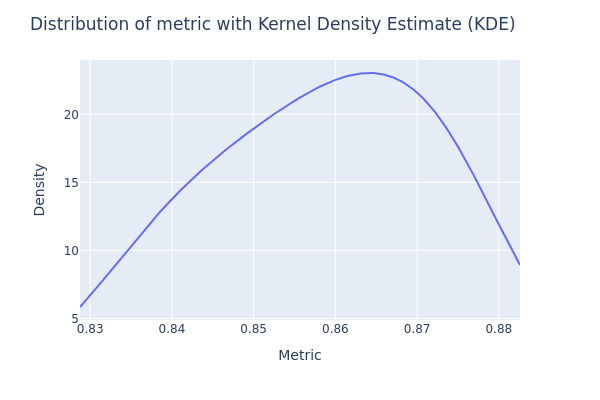

In [135]:
tracker.plot.kde(fig_type="png")

### Reference Plot

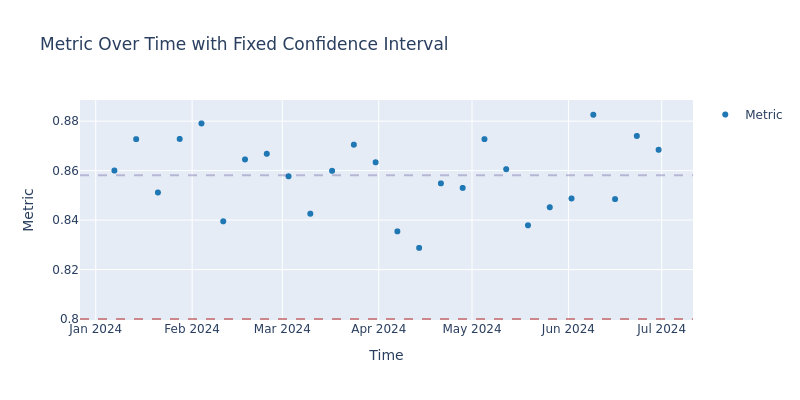

In [136]:
tracker.plot.scatter(tracker.reference_distribution, fig_type="png")

### Analysis Plot

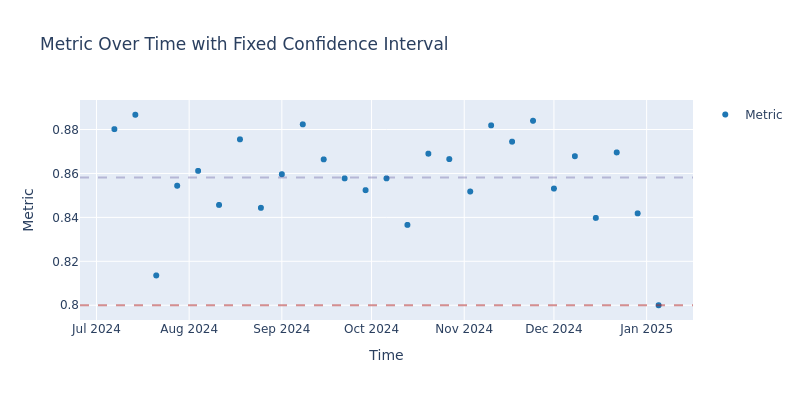

In [137]:
y_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["target"].apply(np.asarray)
y_pred_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["prediction"].apply(np.asarray)
analysis_score = tracker.score(y_grouped, y_pred_grouped)
tracker.plot.scatter(analysis_score, fig_type="png")

# Discrete Data Drift

### Median Absolute Deviation (MAD)

In [138]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_1"].apply(np.asarray)
tracker = CategoricalDriftTracker(df_grouped, func="l_infinity", drift_limit='mad', cumulative=False)

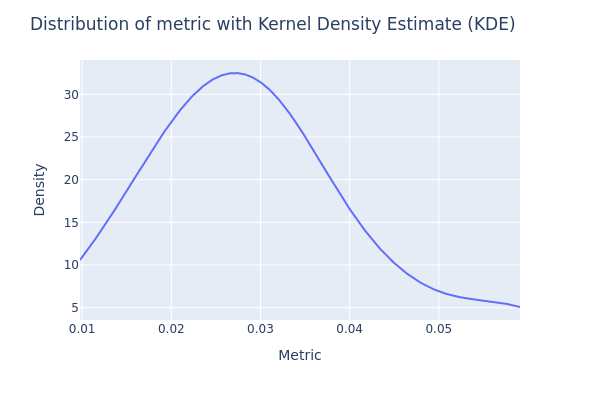

In [139]:
tracker.plot.kde(fig_type="png")

#### Reference Plot

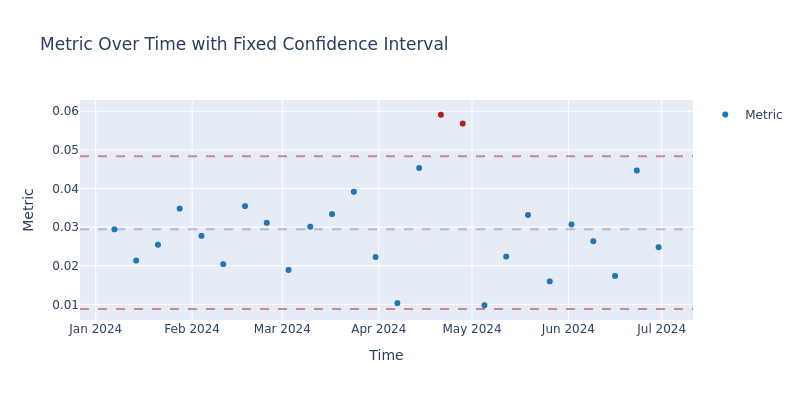

In [140]:
tracker.plot.scatter(tracker.reference_distance, fig_type="png")

In [141]:
chebyshev_guaranteed_percentage(tracker.reference_distance, [tracker.statistics["lower_limit"], tracker.statistics["upper_limit"]])

0.5901339037208426

#### Reference Analysis

In [142]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_1"].apply(np.asarray)

In [143]:
analysis_score = tracker.score(df_grouped)

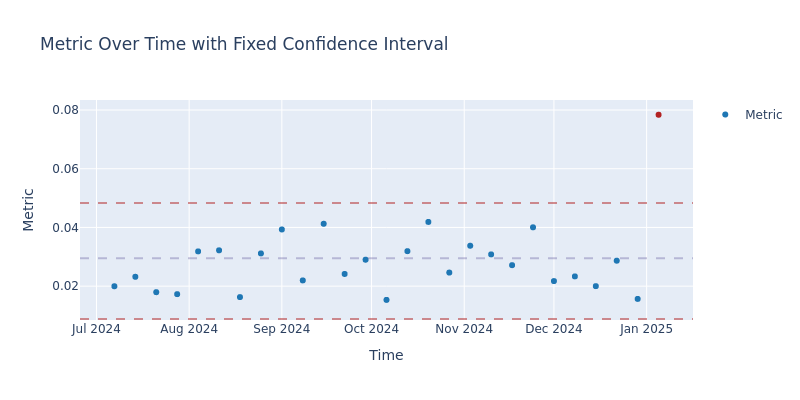

In [144]:
tracker.plot.scatter(analysis_score, fig_type="png")

### Interquartile Range (iqr)

In [145]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_0"].apply(np.asarray)
tracker = CategoricalDriftTracker(df_grouped, drift_limit="iqr", confidence_interval=True, cumulative=True)

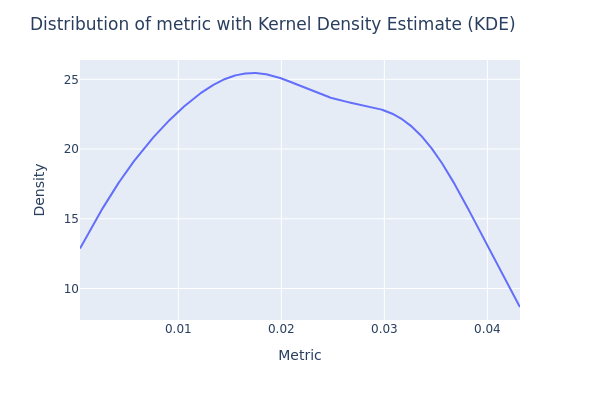

In [146]:
tracker.plot.kde(fig_type="png") 

#### Reference Plot

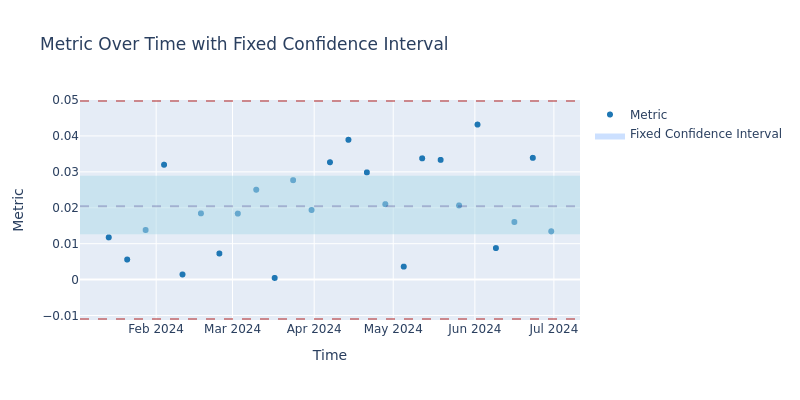

In [147]:
tracker.plot.scatter(tracker.reference_distance, fig_type="png")

In [148]:
chebyshev_guaranteed_percentage(tracker.reference_distance, [tracker.statistics["lower_limit"], tracker.statistics["upper_limit"]])

0.8324482417113273

#### Reference Analysis

In [149]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_0"].apply(np.asarray)

In [150]:
analysis_score = tracker.score(df_grouped)

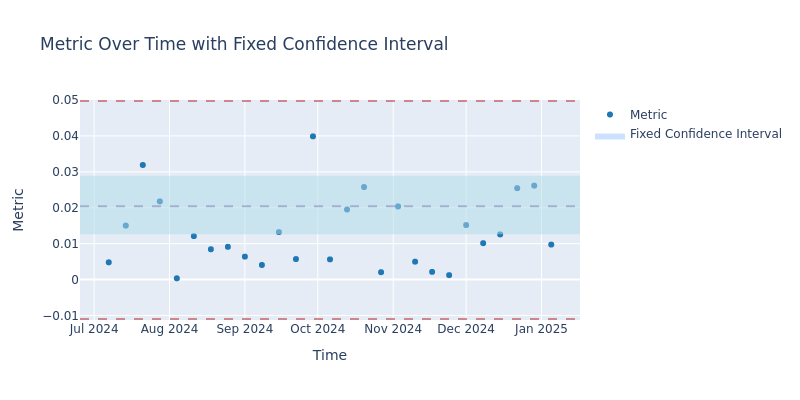

In [151]:
tracker.plot.scatter(analysis_score, fig_type="png")

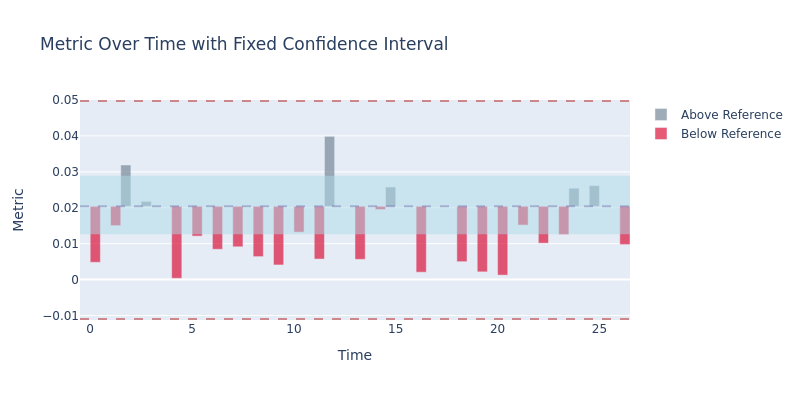

In [152]:
tracker.plot.bar(analysis_score, fig_type="png")

### Quantile Interval & Jacknife Method

In [153]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["discrete_0"].apply(np.asarray)
tracker = CategoricalDriftTracker(df_grouped, drift_limit=("quantile", None, 0.95), confidence_interval=True, cumulative=False)

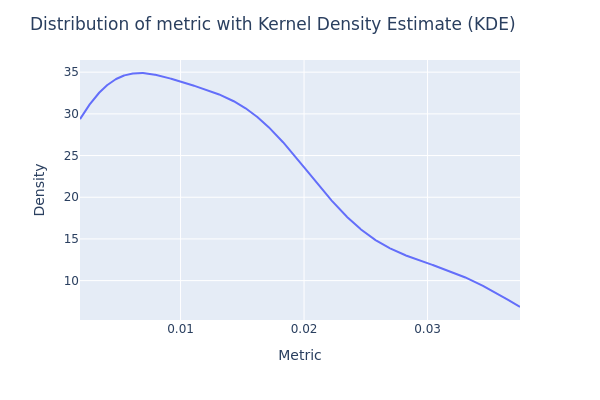

In [154]:
tracker.plot.kde(fig_type="png") 

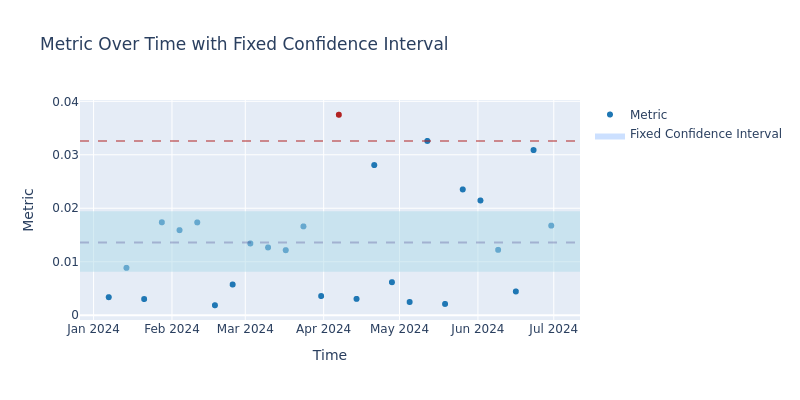

In [155]:
tracker.plot.scatter(tracker.reference_distance, fig_type="png")

# Continuous Data Drift

## Wasserstein Distance

In [156]:
def percentile_threshold(data: pd.DataFrame):
    """Calculates thresholds using the 95th percentiles."""
    lower_limit = None
    upper_limit = np.percentile(data, 95, method="higher")
    return lower_limit, upper_limit

In [157]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["feature_1"].apply(np.asarray)
ws = ContinuousDriftTracker(df_grouped, func="ws", drift_limit=percentile_threshold, confidence_interval=True, cumulative=True)

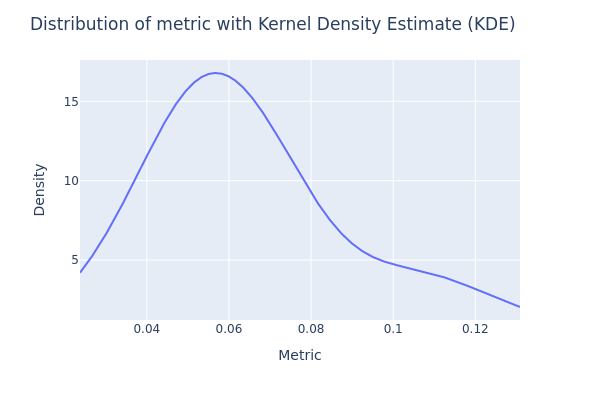

In [158]:
ws.plot.kde(fig_type="png")

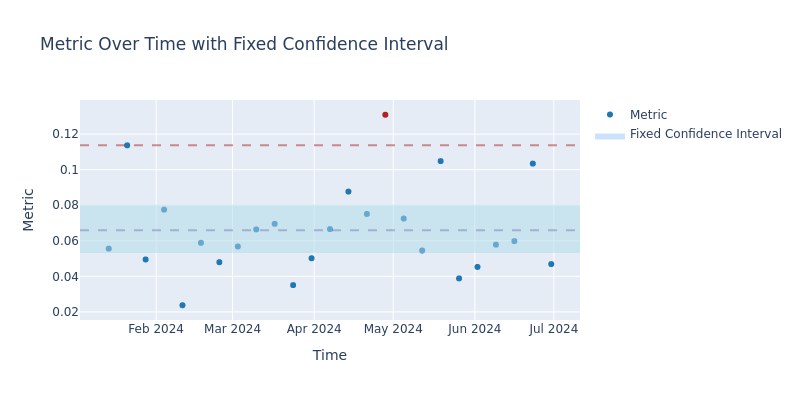

In [159]:
ws.plot.scatter(ws.reference_distance, fig_type="png")

In [160]:
chebyshev_guaranteed_percentage(ws.reference_distance, [ws.statistics["lower_limit"], ws.statistics["upper_limit"]])

0.7236272139722689

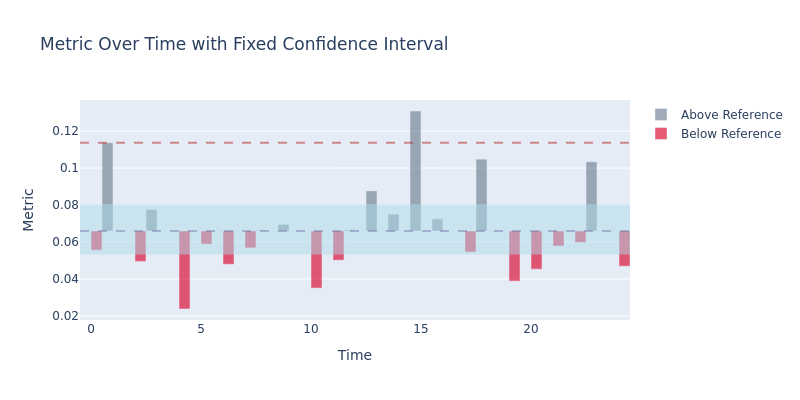

In [161]:
ws.plot.bar(ws.reference_distance, fig_type="png")

In [162]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["feature_1"].apply(np.asarray)
test_ws = ws.score(df_grouped)

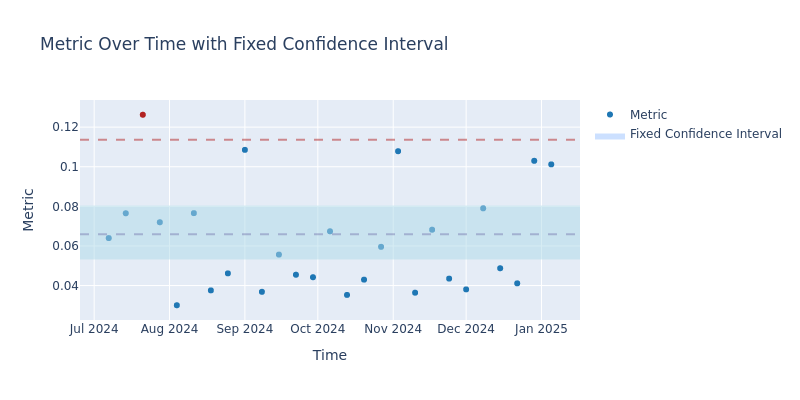

In [163]:
ws.plot.scatter(test_ws, fig_type="png")

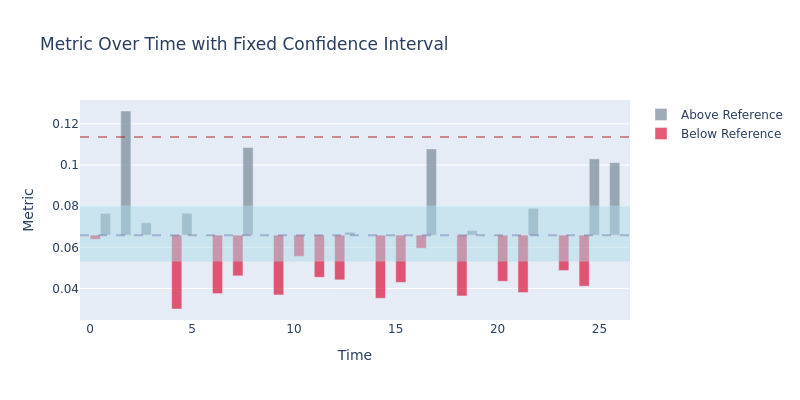

In [164]:
ws.plot.bar(test_ws, fig_type="png")

## Kolmogorov-Smirnov Test

In [165]:
df_grouped = df_reference.groupby(pd.Grouper(key="datetime", freq="W"))["feature_0"].apply(np.asarray)
ks = ContinuousDriftTracker(df_grouped, func="ks", drift_limit=(0.05, None), confidence_interval=True)

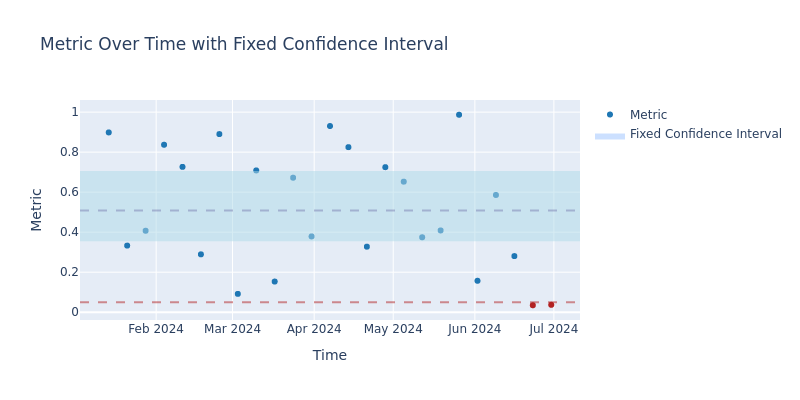

In [166]:
ks.plot.scatter(ks.reference_distance, fig_type="png")

In [167]:
chebyshev_guaranteed_percentage(ks.reference_distance, [ks.statistics["lower_limit"], 1])

0.5834820954235713

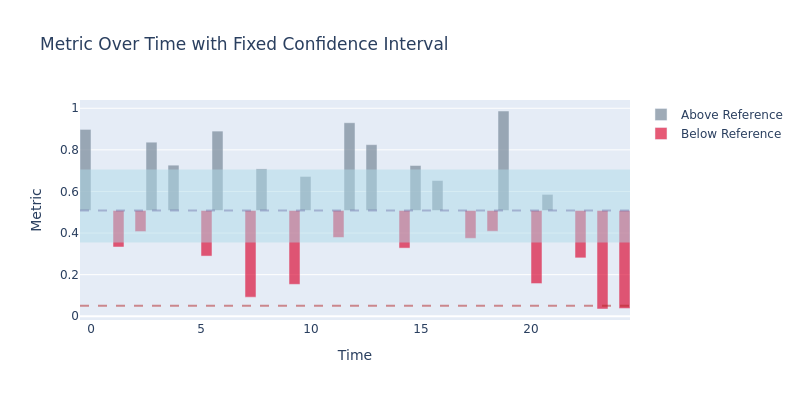

In [168]:
ks.plot.bar(ks.reference_distance, fig_type="png")

In [169]:
df_grouped = df_test.groupby(pd.Grouper(key="datetime", freq="W"))["feature_0"].apply(np.asarray)
test_ks = ks.score(df_grouped)

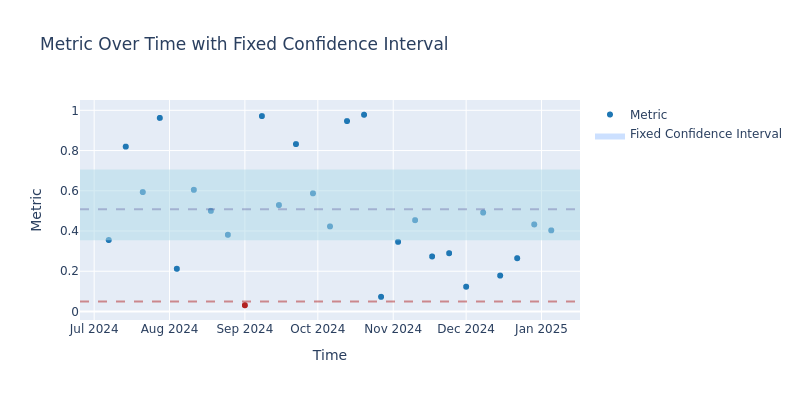

In [170]:
ks.plot.scatter(test_ks, fig_type="png")

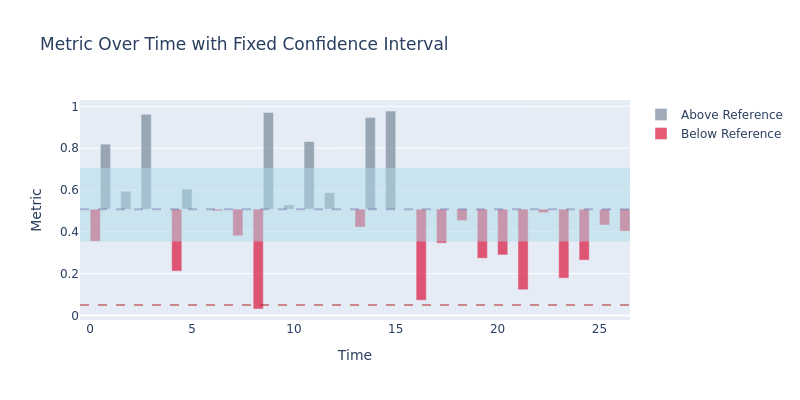

In [171]:
ks.plot.bar(test_ks, fig_type="png")

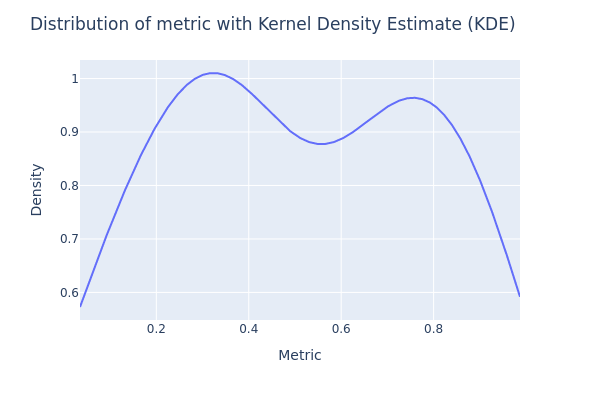

In [172]:
ks.plot.kde(fig_type="png")

# Hurst Exponent

In [173]:
np.random.seed(42)
n_points = 1000
trend = np.linspace(0, 10, n_points)
noise_trend = np.cumsum(standard_normal(n_points) * 0.1)
mean_reversion = np.zeros(n_points)
for t in range(1, n_points):
    mean_reversion[t] = mean_reversion[t-1] * 0.6 + standard_normal() * 0.5
brownian = np.cumsum(standard_normal(n_points))

In [174]:
hurst_exponent(noise_trend)

(0.6419241912818302, 0.000952023886777138)

In [175]:
hurst_exponent(mean_reversion)

(0.3685698852341455, 0.05402692976986088)

# ForeCA

In [176]:
t = np.linspace(0, 10, 1000)
pure_sine = np.sin(2 * np.pi * 1 * t)  # Perfectly forecastable
foreca(pure_sine)

0.9993976808641186

In [177]:
white_noise = np.random.normal(size=1000)  # Not forecastable
foreca(white_noise)

0.06402814937931622